In [1]:
from __future__ import print_function
# Specify where PyCaffe is
caffe_path = '../../caffe_gt/python'

# Import Numpy and Caffe plus a few other utilities
import sys, os, math, random, time, urllib, gzip
import numpy as np
import pickle as cPickle
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
sys.path.append(caffe_path)
import caffe
from caffe import layers as L
from caffe import params as P
from caffe import to_proto

../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for caffe::LayerParameter already registered; second conversion method ignored.
  from ._caffe import \
../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for caffe::SolverParameter already registered; second conversion method ignored.
  from ._caffe import \
../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._caffe import \


MNIST data available


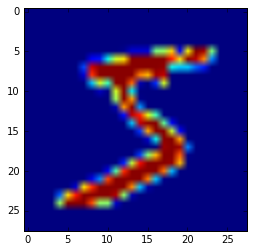

In [2]:
# Download the MNIST data set, if not done already
if not os.path.isfile('../data/mnist.pkl.gz'):
    print('Downloading MNIST...')
    urllib.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz',
                    '../data/mnist.pkl.gz')

# Unzip the MNIST data set, if not done already
if not os.path.isfile('../data/mnist.pkl'):
    print('Unzipping MNIST...')
    input_file = gzip.open('../data/mnist.pkl.gz', 'rb')
    output_file = open('../data/mnist.pkl', 'wb')
    try:
        output_file.write(input_file.read())
    finally:
        input_file.close()
        output_file.close()

print('MNIST data available')

# Load the data
f = open('../data/mnist.pkl', 'rb')
training_data, validation_data, test_data = cPickle.load(f)
f.close()
plt.imshow(np.reshape(training_data[0][0],(28,28)))
plt.show()

In [3]:
# Create the MNIST CNN network
net = caffe.NetSpec()
net.mnist_image = L.Input(input_param=dict(shape=dict(dim=[1,1,28,28])), ntop=1)
net.label = L.Input(input_param=dict(shape=dict(dim=[1,1,1,1])), ntop=1)
net.conv1 = L.Convolution(net.mnist_image,param=[dict(lr_mult=1),dict(lr_mult=2)],
                         convolution_param=dict(num_output=20,kernel_size=5,stride=1,
                                                weight_filler=dict(type='xavier')),
                                                bias_filler=dict(type='constant'))
net.pool1 = L.Pooling(net.conv1,
                         pooling_param=dict(pool=0,kernel_size=2,stride=2))
net.conv2 = L.Convolution(net.pool1,param=[dict(lr_mult=1),dict(lr_mult=2)],
                         convolution_param=dict(num_output=50,kernel_size=5,stride=1,
                                                weight_filler=dict(type='xavier')),
                                                bias_filler=dict(type='constant'))
net.pool2 = L.Pooling(net.conv2,
                         pooling_param=dict(pool=0,kernel_size=2,stride=2))

net.ip1 = L.InnerProduct(net.pool2,param=[dict(lr_mult=1),dict(lr_mult=2)],
                         inner_product_param = dict(num_output = 500,
                                                    weight_filler = dict(type='xavier'),
                                                    bias_filler = dict(type='constant')))
net.relu1 = L.ReLU(net.ip1,in_place=True)
net.ip2 = L.InnerProduct(net.ip1,param=[dict(lr_mult=1),dict(lr_mult=2)],
                         inner_product_param = dict(num_output = 10,
                                                    weight_filler = dict(type='xavier'),
                                                    bias_filler = dict(type='constant')))

net.loss = L.SoftmaxWithLoss(net.ip2,net.label,include=dict(phase=0))
net.pred = L.Softmax(net.ip2,include=dict(phase=1))

protonet = net.to_proto()
protonet.name = 'net'
with open(protonet.name + '.prototxt', 'w') as f:
    print(protonet, file=f)

In [4]:
# Switch Caffe to GPU Mode
caffe.set_mode_gpu()
# Count available GPUs
print(caffe.enumerate_devices(True))
# Select the first GPU
caffe.set_device(0)

5


In [5]:
# Create a solver with a few typical parameters
# The solver will perform SGD on our data
solver_config = caffe.SolverParameter()
solver_config.train_net = 'net.prototxt'
solver_config.base_lr = 0.001
solver_config.momentum = 0.95
solver_config.weight_decay = 0.00005
solver_config.lr_policy = 'inv'
solver_config.gamma = 0.001
solver_config.power = 0.75
solver_config.max_iter = 8000
solver_config.snapshot = 500
solver_config.snapshot_prefix = 'net'
solver_config.type = 'Adam'
solver_config.display = 1

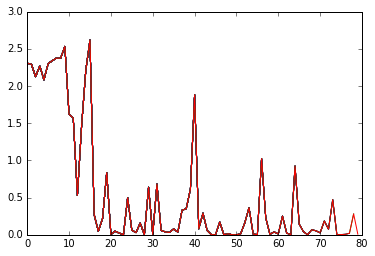

In [6]:
# Do the training
losses = []
solver = caffe.get_solver(solver_config)
for i in range(0,solver_config.max_iter):
    # Pick a random sample for training
    k = random.randint(0,len(training_data[0])-1)
    # Load the sample into the network
    solver.net.blobs['mnist_image'].data[:] = np.reshape(training_data[0][k],(28,28)).astype(float)/255.0
    solver.net.blobs['label'].data[0] = training_data[1][k]
    # Train one step
    loss = solver.step(1)
    # Display the learning progress every 20 steps
    if (i % 100 == 0):
        losses.append(loss)
        plt.plot(losses)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

In [7]:
# Test how accurate the network has learned it's task
error = 0
testnet = caffe.Net(str('net.prototxt'), 'net_iter_8000.caffemodel', caffe.TEST)
for k in range(0,len(validation_data[0])):
    testnet.blobs['mnist_image'].data[:] = np.reshape(validation_data[0][k],(28,28)).astype(float)/255.0
    testnet.forward()
    predicted_number = np.argmax(testnet.blobs['pred'].data[:])
    print('Predicted: '+str(predicted_number)+', actual: '+str(validation_data[1][k]))
    if not (predicted_number == validation_data[1][k]):
        error += 1
print('Errors: '+str(error)+' of '+str(len(validation_data[0]))+' ('+str(100.0-100.0*((float)(error)/(float)(len(validation_data[0]))))+'% accuracy)')

Predicted: 3, actual: 3
Predicted: 8, actual: 8
Predicted: 6, actual: 6
Predicted: 9, actual: 9
Predicted: 6, actual: 6
Predicted: 4, actual: 4
Predicted: 5, actual: 5
Predicted: 5, actual: 3
Predicted: 8, actual: 8
Predicted: 4, actual: 4
Predicted: 5, actual: 5
Predicted: 2, actual: 2
Predicted: 3, actual: 3
Predicted: 8, actual: 8
Predicted: 9, actual: 4
Predicted: 8, actual: 8
Predicted: 1, actual: 1
Predicted: 5, actual: 5
Predicted: 0, actual: 0
Predicted: 5, actual: 5
Predicted: 9, actual: 9
Predicted: 7, actual: 7
Predicted: 4, actual: 4
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 5, actual: 3
Predicted: 0, actual: 0
Predicted: 6, actual: 6
Predicted: 2, actual: 2
Predicted: 9, actual: 9
Predicted: 9, actual: 9
Predicted: 4, actual: 4
Predicted: 1, actual: 1
Predicted: 3, actual: 3
Predicted: 6, actual: 6
Predicted: 8, actual: 8
Predicted: 0, actual: 0
Predicted: 7, actual: 7
Predicted: 7, actual: 7
Predicted: 6, actual: 6
Predicted: 8, actual: 8
Predicted: 9, ac